# Landline vs Mobile Analysis - ATT & CTL

by `Xiaoli Qiu`

created: `2022-04-20`

Jira: [ONE-6703](https://clearlink.atlassian.net/browse/ONE-6703) <br>
<br>


### Executive Summary:
- `line_type` (landline vs mobile) does not seem to be independent of `is_converted`, and various other variables. Jump to [ATT](#att) and [CTL](#ctl) sections to see the details of the chi-square test results.
- Adding `line_type` into the [model](#tldr) does not seem to move the needle much, especially for CTL (any value could be considered to be minimal). 

<br>

__Content__
- [Chi-Square Tests](#chi_square)
    - [ATT](#att)
    - [CTL](#ctl)
- [Model Training with LineType](#training)
    - [CTL Training](#training_ctl)
    - [ATT Training](#training_att)

In [157]:
import datetime
print('Last time updated: ', datetime.datetime.now())

Last time updated:  2022-04-21 10:58:04.025665


In [2]:
import pandas as pd
import numpy as np 

In [3]:
from scipy.stats import chi2_contingency 

In [4]:
import matplotlib.pyplot as plt  
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

import plotly.express as px

In [5]:
# Set universal font size
plt.rcParams.update({'font.size': 20})

# plt.rc('figure', figsize=(20, 6))

In [6]:
def chi_square_test(df):
    """
    Function for performing chi-square test.
    :param df: targe dataframe
    :return: (1) chi-square values in dataframe and (2) p-values in dataframe. The columns names and index are the same. 
    """
    cols = list(df.columns)
    resultant_p = pd.DataFrame(data=[(0 for i in range(len(cols))) for i in range(len(cols))], 
                         columns=cols)
    resultant_p.set_index(pd.Index(cols), inplace = True)
    resultant_chi = resultant_p.copy(deep=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in cols:
        for j in cols:
            if i != j:
                chi2_val, p_val, _, _ = chi2_contingency(pd.crosstab(df[i], df[j]))
#                 chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                resultant_p.loc[i,j] = p_val
                resultant_chi.loc[i,j] = chi2_val
                
    return tuple([resultant_chi, resultant_p])


In [7]:
import psycopg2

In [61]:
con = psycopg2.connect(dbname = 'datawarehouse', host ='dw_prod.clearlinkdata.com', 
                       port = '5439', user = username, password = password)

# con = psycopg2.connect(dbname = 'datawarehouse_stage', host ='dw_stage.clearlinkdata.com', 
#                        port = '5439', user = username, password = password)""

In [69]:
get_data = """
-- 813: Linetype = mobile
-- 814: Linetype = landline
-- 838: Linetype = mobile (Twilio override)
SELECT DISTINCT cdr.contact_id, cd.date_prequeue, cd.brand_skilled,  cd.marketing_tier,
       cd.max_speed_qual, cd.intent_lookup_flag, cd.consent_flag,
       cd.is_converted, lc.description
FROM data_warehouse.call_detail_attribute_log cd
LEFT JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cd.contact_id =  cdr.contact_id
LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lc ON lc.id = cdr.lookup_cd_ivr_route_ids_id
WHERE lookup_cd_ivr_route_ids_id IN (813, 814, 838)
AND cd.brand_skilled IN {brands_skilled}
AND cd.max_speed_qual in {valid_speeds}
AND cd.date_prequeue BETWEEN '2021-12-07' AND '2022-03-31'
AND cd.call_conclusion = 'Answered'
ORDER BY cdr.contact_id;
"""

In [71]:
valid_sq_speeds_ctl = [940, 80, 60, 100, 140, 40, 30, 20, 10, 15, 2, 3, 6, 0]
revenue_limit_ctl = [20, 600]
brand_skilled_ctl = ["QWE", "CLC", "EMB"]
marketing_groups_ctl = {"Tier 1": "G1", "Tier 2": "G2","Tier 3": "G3","MISC": "G2","": "G4","GoDark Other": "G4",
                        "Clearlink ENS CTL.com Organic": "G5", "Clearlink CRIS CTL.com Organic": "G5", "MKT": "G5", "Non Digital ACQ": "G5", 
                        "Tier 2 Agency": "G5", "Tier 1 Agency": "G5", "Tier 3 Agency": "G5", "Local Pages": "G5"}

max_valid_speeds_ctl = "({valid_speeds}, 'NA')".format(valid_speeds=', '.join(map(str, ["'{x}'".format(x=x) for x in valid_sq_speeds_ctl])))
brands_skilled_ctl ="({skilled})".format(skilled=", ".join("'" + item + "'" for item in brand_skilled_ctl))

In [72]:
valid_sq_speeds_att = [5000, 1000, 75, 50, 18, 10, 25, 100, 5, 2, 1, 0]
revenue_limit_att = [20, 600]
brand_skilled_att = ['ATT']

max_valid_speeds_att = "({valid_speeds}, 'NA')".format(valid_speeds=', '.join(map(str, ["'{x}'".format(x=x) for x in valid_sq_speeds_att])))
brands_skilled_att ="({skilled})".format(skilled=", ".join("'" + item + "'" for item in brand_skilled_att))

In [73]:
df_att = pd.read_sql_query(get_data.format(brands_skilled=brands_skilled_att, valid_speeds=max_valid_speeds_att), con)
df_ctl = pd.read_sql_query(get_data.format(brands_skilled=brands_skilled_ctl, valid_speeds=max_valid_speeds_ctl), con)

In [77]:
df_ctl.head()

contact_id date_prequeue brand_skilled      marketing_tier  \
0  193623732534    2021-12-07           CLC     Non Digital ACQ   
1  193623733562    2021-12-07           EMB                MISC   
2  193623734865    2021-12-07           CLC                 MKT   
3  193623738238    2021-12-07           EMB  Tier 3 CenturyLink   
4  193623740815    2021-12-07           EMB              Tier 1   

  max_speed_qual  intent_lookup_flag  consent_flag  is_converted  \
0             NA                   1             1             0   
1             NA                   2             1             1   
2              3                   1             0             1   
3             NA                   2             1             0   
4             20                   2             0             0   

         description  
0  LineType Wireless  
1  LineType Wireless  
2  LineType Wireless  
3  LineType Wireless  
4  LineType Landline

In [78]:
df_att = df_att.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'], keep="first")
df_ctl = df_ctl.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'], keep="first")

In [86]:
(len(df_ctl) == df_ctl['contact_id'].nunique()) & (len(df_att) == df_att['contact_id'].nunique())

True

In [87]:
# Make landline as linetype 1, mobile as linetype 2
df_att['line_type'] = np.where(df_att['description']=='LineType Landline', 1, 2)
df_ctl['line_type'] = np.where(df_ctl['description']=='LineType Landline', 1, 2)
df_ctl.head()

contact_id date_prequeue brand_skilled      marketing_tier  \
31452  194545921521    2021-12-30           EMB              Tier 2   
39270  194753308198    2022-01-05           CLC     Non Digital ACQ   
74176  195790510647    2022-01-31           EMB  Tier 3 CenturyLink   
74175  195790510524    2022-01-31           EMB              Tier 2   
74174  195790510488    2022-01-31           CLC     Non Digital ACQ   

      max_speed_qual  intent_lookup_flag  consent_flag  is_converted  \
31452             20                   1             0             1   
39270              0                   1             1             1   
74176             NA                   2             1             1   
74175             NA                   1             0             1   
74174              0                   1             1             1   

             description  line_type  
31452  LineType Wireless          2  
39270  LineType Wireless          2  
74176  LineType Landline          1  
74175  LineType Wireless          2  
74174  LineType Wireless          2

<a id='chi_square'> </a>

# Chi-Square Tests

<a id='att'> </a>

# ATT

In [88]:
[resultant_chi_att, resultant_p_att] = chi_square_test(df_att[['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'line_type', 'is_converted']])

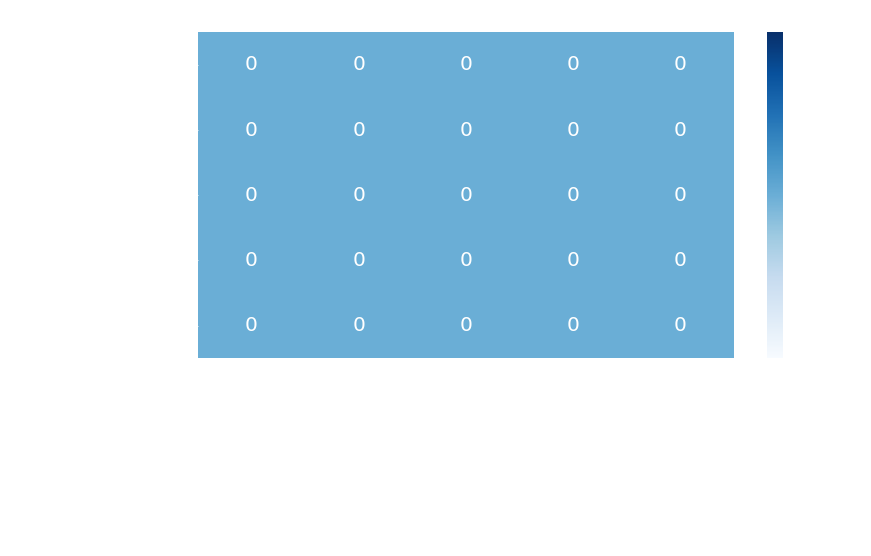

In [89]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_att,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

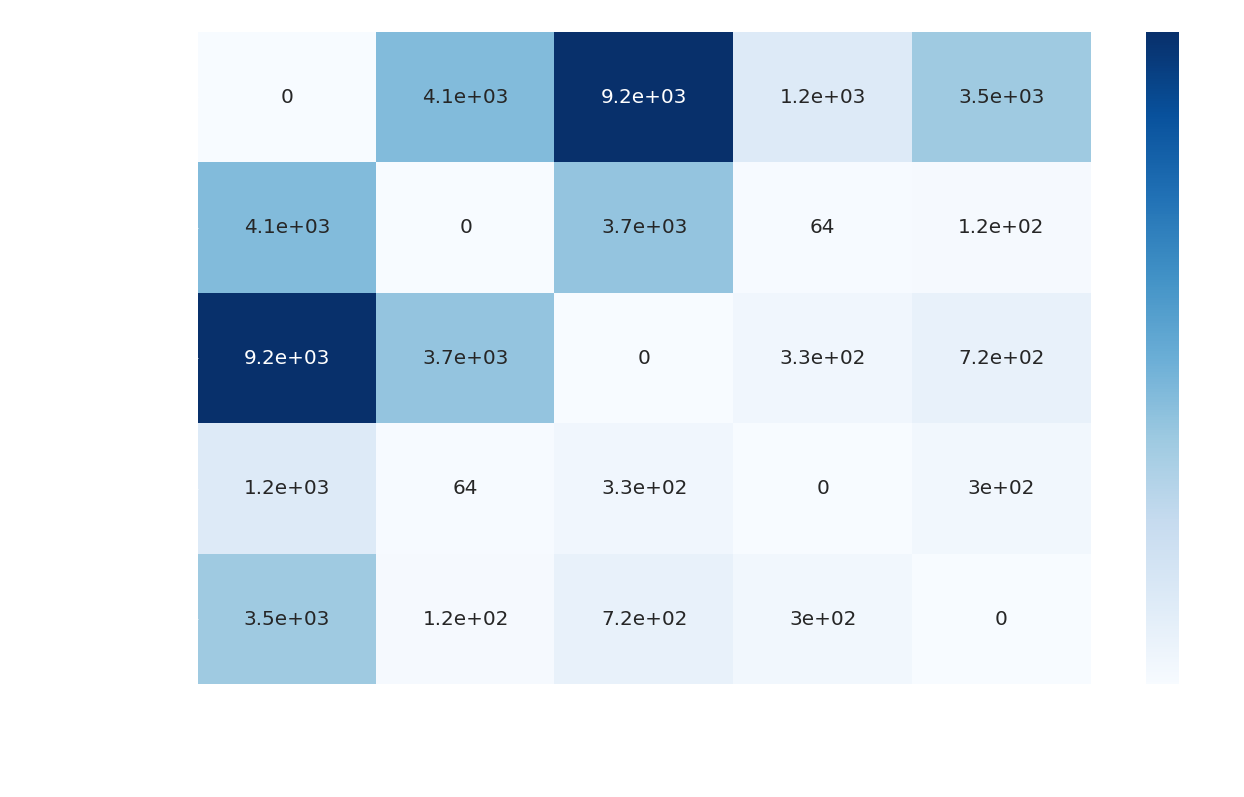

In [90]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_att, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

__Observations:__

It seems `line_ype` is not independent of `max_speed`, `is_converted` and `consent`. 

<a id='ctl'> </a>

# CTL

In [91]:
[resultant_chi_ctl, resultant_p_ctl] = chi_square_test(df_ctl[['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'line_type', 'is_converted']])

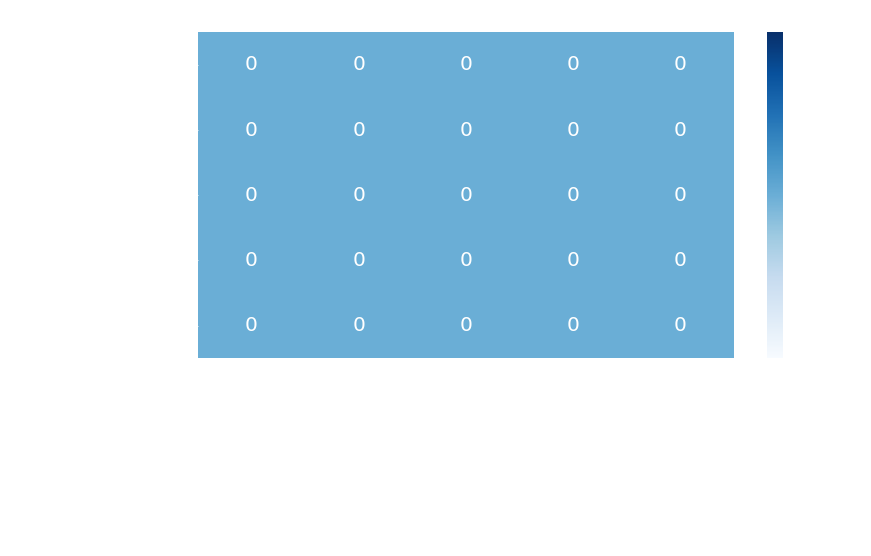

In [94]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_ctl,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

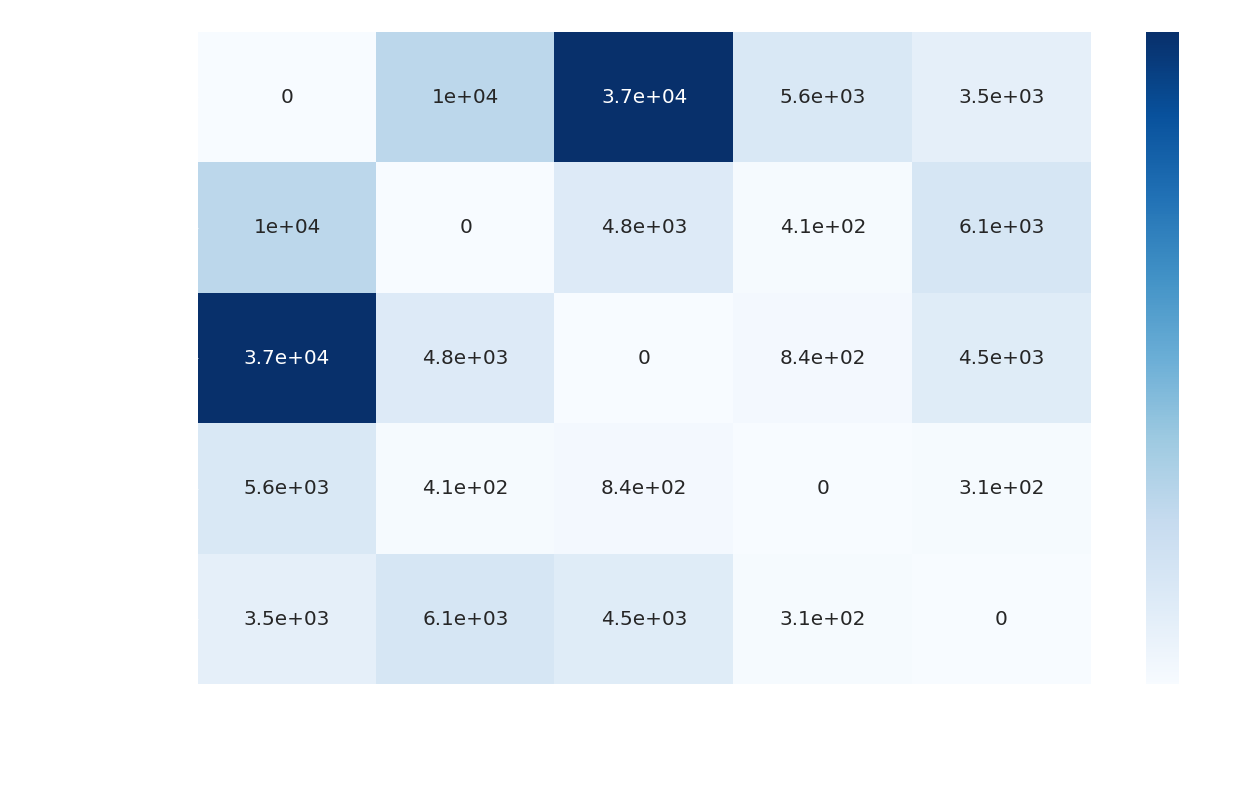

In [95]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_ctl, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

__Observations:__

For CTL, `line_type` does not seem to be independent of `max_speed`,  `consent`, `intent`, and `is_converted`.

<a id='functions_train'> </a>

# Functions for Model Training

In [128]:
get_conv_training_set = """
SELECT date_prequeue, contact_id, brand_skilled, intent_lookup_flag, consent_flag, 
    marketing_tier, max_speed_qual, is_converted
FROM data_warehouse.call_detail_attribute_log
WHERE brand_skilled IN {brands_skilled} 
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND call_conclusion = 'Answered'
ORDER BY 1;
"""

get_revenue_training_set = """
SELECT
*
FROM (
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       cdal.marketing_tier,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow AND cdal.marketing_tier=lfk.marketing_tier
WHERE cdal.brand_ordered IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2)
UNION
(SELECT date_prequeue,
       contact_id,
       brand_skilled,
       intent_lookup_flag,
       consent_flag,
       cdal.marketing_tier,
       max_speed_qual,
       is_converted,
       cdal.sku,
       cdal.unit_count,
       lfk.revenue
FROM data_warehouse.call_detail_attribute_log cdal
         LEFT JOIN data_warehouse.lookup_finance_kpi_sku_revenue_latest lfk
                   ON cdal.sku = lfk.sku AND cdal.brand_marketed = lfk.brand_marketed
                       AND cdal.brand_ordered = lfk.brand_ordered AND
                      cdal.financial_sale_creation_type = lfk.financial_sale_creation_type AND
                      cdal.is_overflow = lfk.is_overflow
WHERE cdal.brand_ordered NOT IN ('EMBC', 'QWEC', 'EMB', 'QWE')
AND brand_skilled IN {brands_skilled}
AND date_prequeue >= '{train_start_date}'
AND date_prequeue <= '{train_end_date}'
AND max_speed_qual in {valid_speeds}
AND is_converted = 1
AND call_conclusion = 'Answered'
ORDER BY 1,2));
"""

get_online_aq_contact_ids = """
SELECT DISTINCT cd.contact_id
FROM data_warehouse.call_detail cd
 JOIN data_warehouse.call_detail_rel_ivr_routes cdr ON cdr.contact_id = cd.contact_id
 LEFT JOIN data_warehouse.lookup_cd_ivr_route_ids lcr ON cdr.lookup_cd_ivr_route_ids_id = lcr.id
WHERE lcr.id IN (691, 746)
AND brand_skilled IN {brands_skilled}
AND DATE(cd.date_prequeue_start) >= '{train_start_date}'
AND DATE(cd.date_prequeue_start) <= '{train_end_date}'
AND call_type = 'I'
AND call_purpose = 'Sales'
AND call_conclusion = 'Answered';
"""

In [101]:
train_start_date = '2021-12-07'
train_end_date = '2022-03-31'

In [129]:
train_set_conv_att = pd.read_sql(get_conv_training_set.format(train_start_date=train_start_date, train_end_date=train_end_date, valid_speeds=max_valid_speeds_att, brands_skilled=brands_skilled_att), con)
train_set_revenue_att = pd.read_sql(get_revenue_training_set.format(train_start_date=train_start_date, train_end_date=train_end_date, valid_speeds=max_valid_speeds_att, brands_skilled=brands_skilled_att), con)
online_aq_ids_att = pd.read_sql(get_online_aq_contact_ids.format(train_start_date=train_start_date, train_end_date=train_end_date, brands_skilled=brands_skilled_att), con)

In [130]:
train_set_conv_ctl = pd.read_sql(get_conv_training_set.format(train_start_date=train_start_date, train_end_date=train_end_date, valid_speeds=max_valid_speeds_ctl, brands_skilled=brands_skilled_ctl), con)
train_set_revenue_ctl = pd.read_sql(get_revenue_training_set.format(train_start_date=train_start_date, train_end_date=train_end_date, valid_speeds=max_valid_speeds_ctl, brands_skilled=brands_skilled_ctl), con)
online_aq_ids_ctl = pd.read_sql(get_online_aq_contact_ids.format(train_start_date=train_start_date, train_end_date=train_end_date, brands_skilled=brands_skilled_ctl), con)

In [131]:
train_set_conv_att

date_prequeue    contact_id brand_skilled  intent_lookup_flag  \
0        2021-12-07  193623731958           ATT                   2   
1        2021-12-07  193624515899           ATT                   2   
2        2021-12-07  193623731958           ATT                   2   
3        2021-12-07  193738518687           ATT                   1   
4        2021-12-07  193623734267           ATT                   1   
...             ...           ...           ...                 ...   
53283    2022-03-31  198162804066           ATT                   2   
53284    2022-03-31  198162807927           ATT                   1   
53285    2022-03-31  198162810253           ATT                   1   
53286    2022-03-31  198162810253           ATT                   1   
53287    2022-03-31  198162812027           ATT                   2   

       consent_flag marketing_tier max_speed_qual  is_converted  
0                 1           MISC             NA             1  
1                 1           MISC             25             0  
2                 1           MISC             NA             1  
3                 0           MISC             NA             0  
4                 1           MISC             25             1  
...             ...            ...            ...           ...  
53283             1           MISC             NA             0  
53284             0           MISC             NA             0  
53285             0           MISC             NA             1  
53286             0           MISC             NA             1  
53287             1           MISC             25             0  

[53288 rows x 8 columns]

In [132]:
df_att_c = df_att.copy(deep=True)
df_att_c['contact_id'] = df_att_c['contact_id'].astype('str')
train_set_conv_att_c = pd.merge(train_set_conv_att, df_att_c[['contact_id', 'line_type']], on=['contact_id'], how='left')
train_set_conv_att_c['line_type'].fillna(0, inplace=True)

train_set_revenue_att_c = pd.merge(train_set_revenue_att, df_att_c[['contact_id', 'line_type']], on=['contact_id'], how='left')
train_set_revenue_att_c['line_type'].fillna(0, inplace=True)

train_set_conv_att_c['line_type'].value_counts()

2.0    50069
1.0     2927
0.0      292
Name: line_type, dtype: int64

In [133]:
df_ctl_c = df_ctl.copy(deep=True)
df_ctl_c['contact_id'] = df_ctl_c['contact_id'].astype('str')
train_set_conv_ctl_c = pd.merge(train_set_conv_ctl, df_ctl_c[['contact_id', 'line_type']], on=['contact_id'], how='left')
train_set_conv_ctl_c['line_type'].fillna(0, inplace=True)

train_set_revenue_ctl_c = pd.merge(train_set_revenue_ctl, df_ctl_c[['contact_id', 'line_type']], on=['contact_id'], how='left')
train_set_revenue_ctl_c['line_type'].fillna(0, inplace=True)

train_set_conv_ctl_c['line_type'].value_counts()

2.0    154311
1.0     14102
0.0       425
Name: line_type, dtype: int64

__Observations:__

Not all calls are marked with line type.

In [123]:
# Create the training set
def create_training_set(train_set_conv, train_set_revenue, marketing_groups, online_aq_ids, revenue_limit, cur_date, train_days):
    """
    Function to create training sets for conversion and revenue models
    :param train_set_conv: conversion training set df
    :param train_set_revenue: revenue training set df
    :param marketing_groups: grouped marketing tiers
    :param online_aq_ids: online AQS ids to be excluded
    :param revenue_limit: revenue limits for revenue training set
    :param cur_date: current date
    :param train_days: number of most recent calendar days to be included in the training set
    :return: processed row training set
    """
    # Select appropriate dates for traninig
    train_set_conv['date_prequeue'] = pd.to_datetime(train_set_conv['date_prequeue'])
    train_set_revenue['date_prequeue'] = pd.to_datetime(train_set_revenue['date_prequeue'])
    
    end = datetime.datetime.strptime(cur_date, '%Y-%m-%d').date()
    begin = (end - pd.offsets.Day(train_days)).date()
    
    train_set_conv_dates = train_set_conv[(train_set_conv['date_prequeue'].dt.date <= end) & (train_set_conv['date_prequeue'].dt.date >= begin)]
    train_set_revenue_dates = train_set_revenue[(train_set_revenue['date_prequeue'].dt.date <= end) & (train_set_revenue['date_prequeue'].dt.date >= begin)]
    
    train_set_conv_processed = process_training_set(train_set_conv_dates, marketing_groups, online_aq_ids)
    train_set_revenue_processed = process_rev_training_set(train_set_revenue_dates, revenue_limit, marketing_groups, online_aq_ids)
    
    return tuple([train_set_conv_processed, train_set_revenue_processed])

def process_training_set(train_set, marketing_groups, online_aq_ids):
    """
    Function to build rows for the training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual', 'line_type']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # logging.info('Class ratios before dropping the duplicates: ')
    # logging.info(train_set['is_converted'].value_counts())
    # logging.info(train_set['is_converted'].value_counts(normalize=True) * 100)

    train_set = train_set.sort_values('is_converted', ascending=False).drop_duplicates(subset=['contact_id'],
                                                                                       keep="first")
    train_set.dropna(subset=['marketing_tier_group'], inplace=True)

    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    to_drop = ['date_prequeue', 'brand_skilled', 'contact_id']
    train_set.drop(to_drop, axis=1, inplace=True)
    return train_set

def process_rev_training_set(train_set, revenue_limit, marketing_groups, online_aq_ids):
    """
    Function to build rows for the revenue training set
    :param train_set: training set data frame
    :return: processed row training set
    """
    # logging.info('Number of records: ')
    # logging.info(train_set.shape[0])
    train_set = train_set[~train_set['contact_id'].astype(int).isin(online_aq_ids['contact_id'].astype(int))].copy()
    # logging.info('Number of records after removing online address qual: ')
    # logging.info(train_set.shape[0])

    if marketing_groups is not None:
        train_set['marketing_tier'] = train_set['marketing_tier'].map(marketing_groups)
        train_set['marketing_tier'].fillna('G4', inplace=True)
        # logging.info('Marketing tier ratios: ')
        # logging.info(train_set['marketing_tier'].value_counts())
        # logging.info(train_set['marketing_tier'].value_counts(normalize=True) * 100)
    else:
        train_set.loc[:, 'marketing_tier'] = 'NA'
        # logging.info(train_set['marketing_tier'].unique())

    train_set.rename(columns={'marketing_tier': 'marketing_tier_group'}, inplace=True)

    cols = ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual', 'line_type', 'sku']

    for c in cols:
        train_set[c] = train_set[c].astype('category')

    # aggregate and calculate the revenue for each contact_id
    rev_cal = train_set.assign(fkrs_revenue=train_set.eval('unit_count * revenue')).groupby(
        'contact_id', as_index=False).sum()
    rev_cal.drop(columns=['unit_count', 'revenue', 'is_converted'], inplace=True)

    train_set.drop(columns=['sku', 'unit_count', 'revenue', 'date_prequeue', 'brand_skilled'],
                   inplace=True)
    train_set.drop_duplicates(inplace=True)

    train_set = pd.merge(train_set,
                         rev_cal,
                         how='outer',
                         on='contact_id')

    train_set.dropna(subset=['marketing_tier_group', 'fkrs_revenue'], inplace=True)
    # logging.info('Unique marketing_tier_group values after dropna: ')
    # logging.info(train_set['marketing_tier_group'].unique())

    min_revenue_limit = revenue_limit[0]
    max_revenue_limit = revenue_limit[1]
    train_set = train_set[train_set['fkrs_revenue'].between(min_revenue_limit, max_revenue_limit)]

    train_set.drop(columns=['contact_id'], axis=1, inplace=True)
    return train_set

In [119]:
from statsmodels.api import add_constant
from statsmodels.api import OLS
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from itertools import product
from imblearn.over_sampling import SMOTE 

In [120]:
def build_model_oversample(train_set_conv, train_set_revenue):
    """
    Function that builds the regression model from the training set
    :param train_set_conv: training set for conversion mddel
    :param train_set_revenue: training set for revenue model
    :param brand: model brand
    :return: model objects and report
    """
    train = train_set_conv.drop(['is_converted'], axis=1)
    y = train_set_conv['is_converted']
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train)
    
    X = encoder.transform(train)
    
    oversample = SMOTE(sampling_strategy='minority')
    X, y = oversample.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

    train1 = train_set_revenue.drop(['is_converted', 'fkrs_revenue'], axis=1)
    encoder1 = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder1.fit(train1)
    X1 = encoder1.transform(train1)
    y1 = train_set_revenue['fkrs_revenue']

    # adding bias
    X1_ = np.append(X1,np.ones([len(X1),1]),1)

    model_conv = LogisticRegression(max_iter=500, random_state=10).fit(X_train, y_train)
    model_rev = (OLS(y1, X1_)).fit()

    # logging.info('Revenue model summary: ')
    # logging.info(model_rev.summary())

    print('Revenue model R2: ')
    print(model_rev.rsquared)

    print('Accuracy of Logistic Regression on training set: {:.2f}'.format(model_conv.score(X_train, y_train)))
    print('Accuracy of Logistic Regression on test set: {:.2f}'.format(model_conv.score(X_test, y_test)))

    out = model_conv.predict_proba(X)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, out)
    beta = 1
    f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
    ix = np.argmax(f_score)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f_score[ix]))

    threshold = thresholds[ix]
    y_pred = np.where(out > threshold, 1, 0)

    cnv_model_report = (classification_report(y, y_pred, output_dict=True))

    print('Classification report: ')
    print(pd.DataFrame(cnv_model_report).iloc[:-1, :-2].T)

    return tuple([(model_conv, cnv_model_report), model_rev, encoder, encoder1])

In [134]:
train_days = 180
cur_date = '2022-03-31'
train_set_conv_processed_ctl, train_set_revenue_processed_ctl = create_training_set(train_set_conv_ctl_c, train_set_revenue_ctl_c, marketing_groups_ctl, online_aq_ids_ctl, revenue_limit_ctl, cur_date, train_days)

In [139]:
train_set_conv_processed_att, train_set_revenue_processed_att = create_training_set(train_set_conv_att_c, train_set_revenue_att_c, None, online_aq_ids_att, revenue_limit_att, cur_date, train_days)

In [142]:
train_set_conv_processed_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42361 entries, 0 to 53287
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   intent_lookup_flag    42361 non-null  category
 1   consent_flag          42361 non-null  category
 2   marketing_tier_group  42361 non-null  category
 3   max_speed_qual        42361 non-null  category
 4   is_converted          42361 non-null  int64   
 5   line_type             42361 non-null  category
dtypes: category(5), int64(1)
memory usage: 869.8 KB


In [143]:
train_set_conv_processed_ctl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139200 entries, 82025 to 0
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   intent_lookup_flag    139200 non-null  category
 1   consent_flag          139200 non-null  category
 2   marketing_tier_group  139200 non-null  category
 3   max_speed_qual        139200 non-null  category
 4   is_converted          139200 non-null  int64   
 5   line_type             139200 non-null  category
dtypes: category(5), int64(1)
memory usage: 2.8 MB


## Check Chi-Square Test again

In [147]:
[resultant_chi_att, resultant_p_att] = chi_square_test(train_set_conv_processed_att[['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'line_type', 'is_converted']])

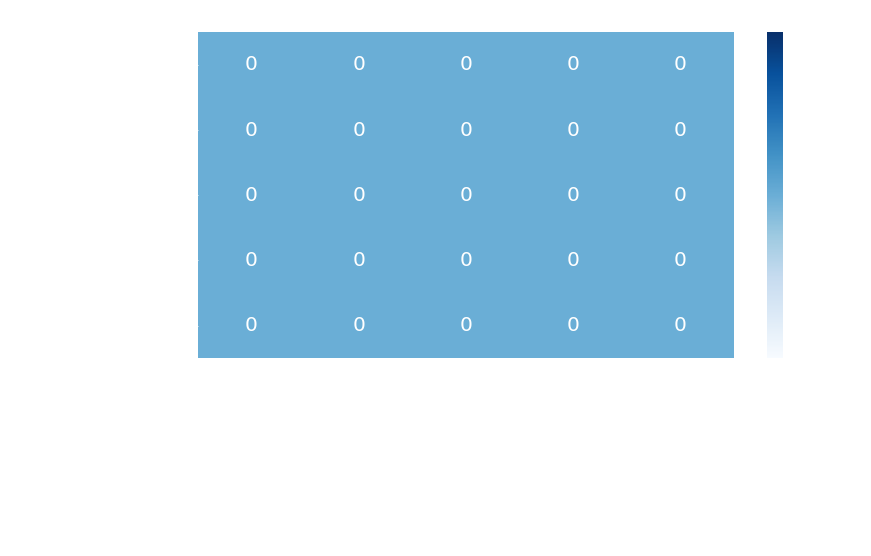

In [148]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_att,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

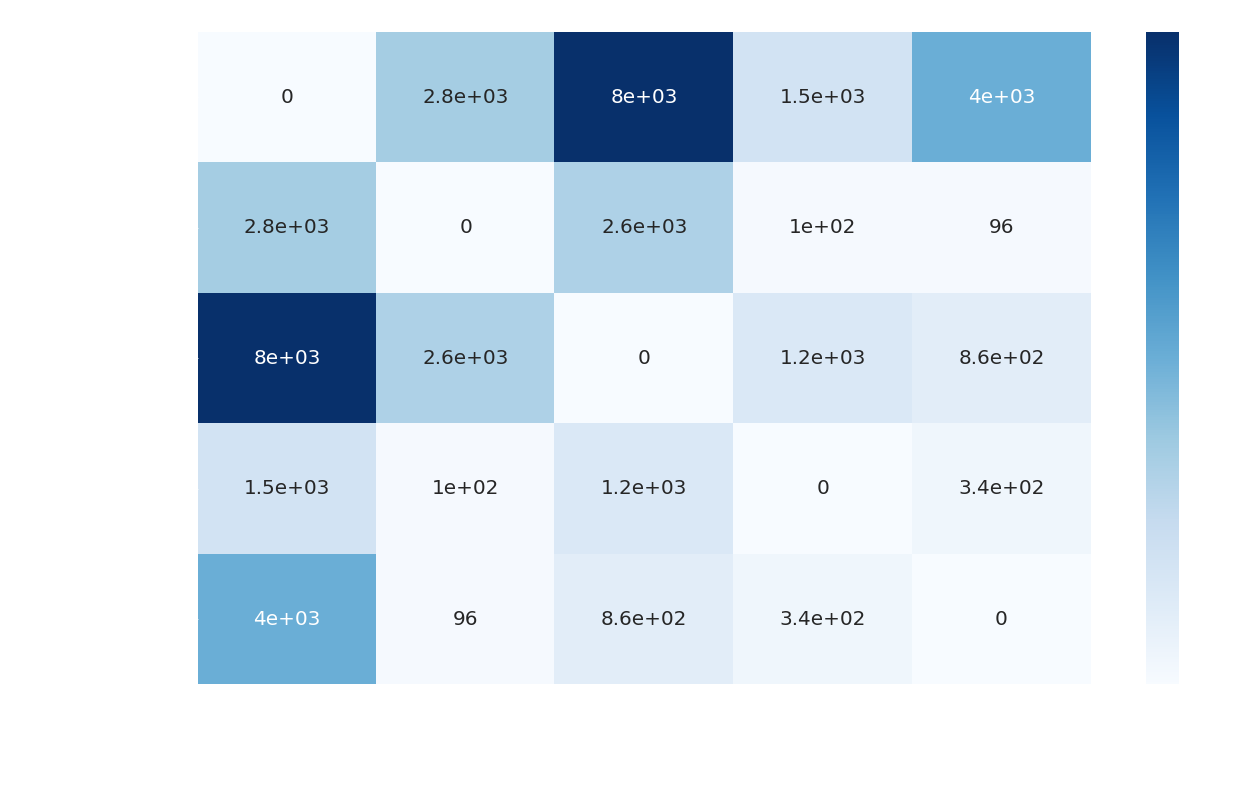

In [149]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_att, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

In [145]:
[resultant_chi_ctl, resultant_p_ctl] = chi_square_test(train_set_conv_processed_ctl[['intent_lookup_flag', 'consent_flag', 'max_speed_qual', 'marketing_tier_group', 'line_type', 'is_converted']])

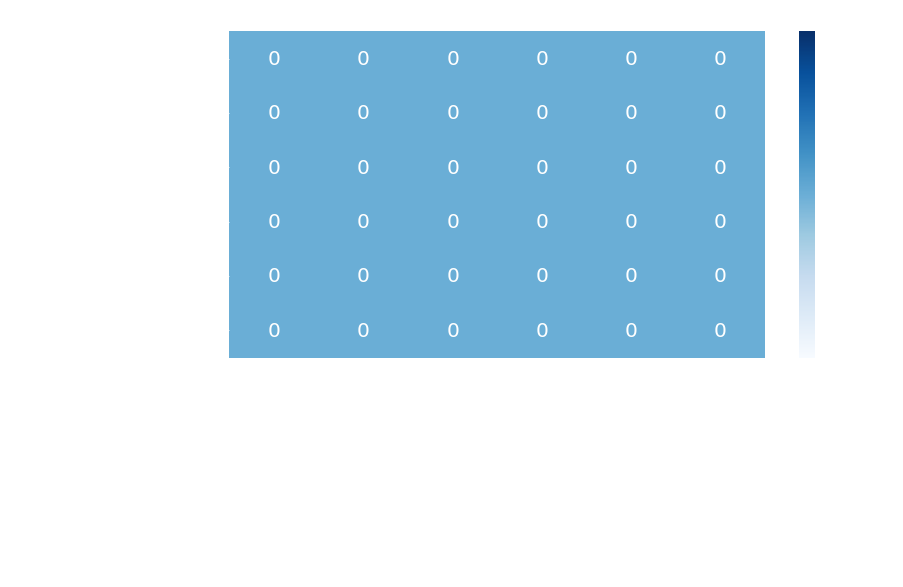

In [150]:
# Plotting p-values
fig = plt.figure(figsize=(12,6))
sns.heatmap(np.round(resultant_p_ctl,4), annot=True, cmap='Blues')
plt.title('Chi-Square Test p-values')
plt.show()

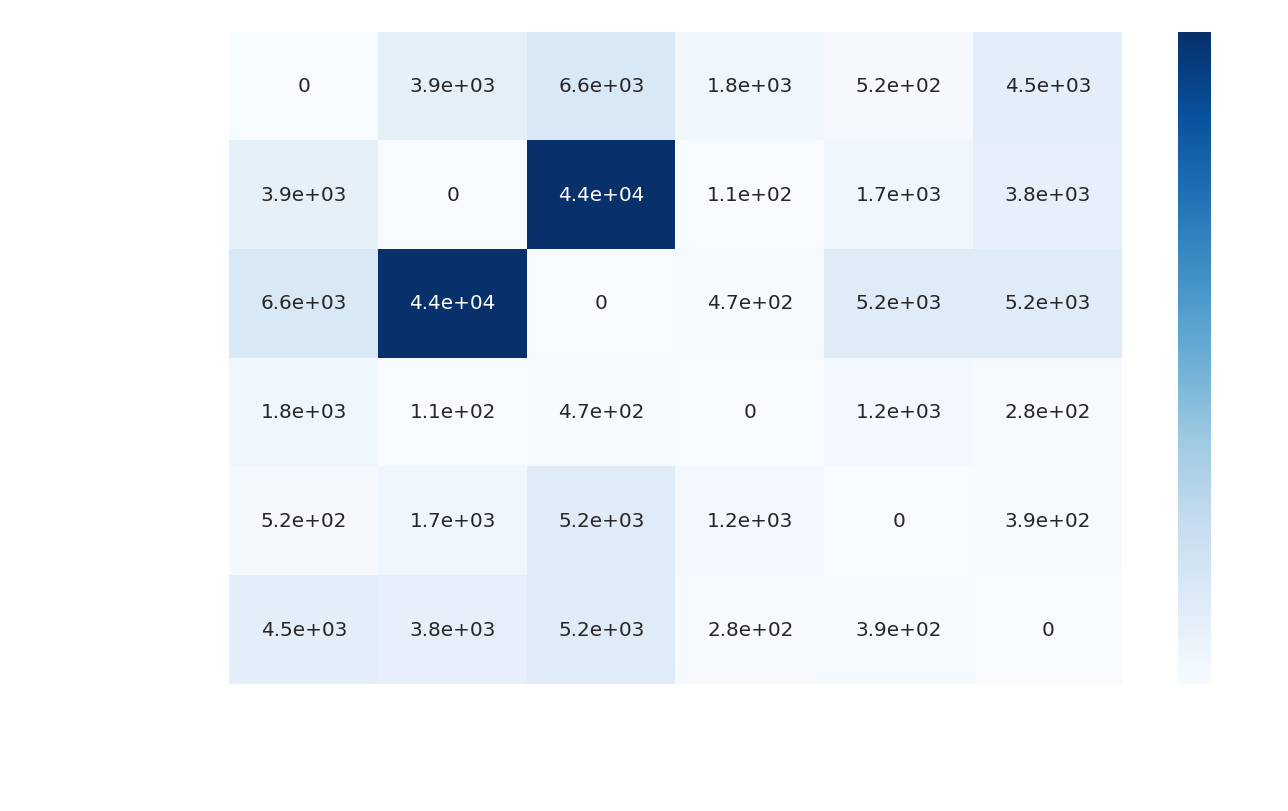

In [146]:
# Plotting chi-square values
bfig = plt.figure(figsize=(20,12))
g = sns.heatmap(resultant_chi_ctl, annot=True, cmap='Blues')
g.set_xticklabels(g.get_xticklabels(), rotation = 30, fontsize = 18)
plt.title('Chi-Square Test chi')
plt.show()

<a id='training'> </a>

# Model Training with LineType

In [153]:
from itertools import combinations

In [151]:
def keep_3_attributes_at_least(train_set_conv_processed, train_set_revenue_processed, attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'consent_flag']):
    """
    
    """
    cols = train_set_conv_processed.drop(columns=['is_converted']).columns
    f1_1_best = 0
    f1_0_best = 0
    accuracy_best = 0
    recall_1_best = 0
    cols_best = cols
    dict_save = {'f1_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                'f1_0_best': {'cols_best': cols_best, 'conv_model_report': None},
                'accuracy_best': {'cols_best': cols_best, 'conv_model_report': None},
                'recall_1_best': {'cols_best': cols_best, 'conv_model_report': None},
                }

    # keeping the attributes in the attri_keep_list, add at least 1 other attribute
    cols_combs = []
    for L in range(0, len(cols)+1):
        for subset in combinations(cols, L):
            if (len(subset) >= 4) & (all(elem in subset for elem in attri_keep_list)):    
                cols_combs.append(list(subset))
#     print(cols_combs)
                
    for cols_comb in cols_combs:
        print('-----------------')
        print('Current attributes: ', cols_comb)
        train_set_conv_processed_d = pd.concat([train_set_conv_processed[cols_comb], train_set_conv_processed['is_converted']], axis= 1)
        train_set_revenue_processed_d = pd.concat([train_set_revenue_processed[cols_comb], train_set_revenue_processed[['is_converted', 'fkrs_revenue']]], axis= 1)

        (mdl_conv_new, conv_model_report_new), mdl_rev_new, encoder_conv_new, encoder_rev_new = build_model_oversample(train_set_conv_processed_d, train_set_revenue_processed_d)
        f1_1_cur = conv_model_report_new['1']['f1-score']
        f1_0_cur = conv_model_report_new['0']['f1-score']
        accuracy_cur = conv_model_report_new['accuracy']
        recall_1_cur = conv_model_report_new['1']['recall']
        
        if (f1_1_cur > f1_1_best):
            dict_save['f1_1_best']['cols_best'] = cols_comb
            dict_save['f1_1_best']['conv_model_report'] = conv_model_report_new
            f1_1_best = f1_1_cur
        elif (f1_0_cur > f1_0_best):
            dict_save['f1_0_best']['cols_best'] = cols_comb
            dict_save['f1_0_best']['conv_model_report'] = conv_model_report_new
            f1_0_best = f1_0_cur
        elif (accuracy_cur >= accuracy_best):
            dict_save['accuracy_best']['cols_best'] = cols_comb
            dict_save['accuracy_best']['conv_model_report'] = conv_model_report_new
            accuracy_best = accuracy_cur
        elif recall_1_cur > recall_1_best: 
            dict_save['recall_1_best']['cols_best'] = cols_comb
            dict_save['recall_1_best']['conv_model_report'] = conv_model_report_new
            recall_1_best = recall_1_cur
            
    print('Best combination of attributes that yields the best accuracy if: ', dict_save['accuracy_best']['cols_best'])

    return tuple([cols_combs, dict_save])

<a id='training_ctl'> </a>

## CTL Training 

In [154]:
all_combs_ctl, best_attritubes_ctl = keep_3_attributes_at_least(train_set_conv_processed_ctl, 
                                                                train_set_revenue_processed_ctl, 
                                                                attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'marketing_tier_group'])

-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual']
Revenue model R2: 
0.5830395241981929
Accuracy of Logistic Regression on training set: 0.62
Accuracy of Logistic Regression on test set: 0.61
Best Threshold=0.360251, F-Score=0.682
Classification report: 
          precision    recall  f1-score
0          0.724886  0.251084  0.372977
1          0.547106  0.904707  0.681865
accuracy   0.577895  0.577895  0.577895
-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual', 'line_type']
Revenue model R2: 
0.5845645131608753
Accuracy of Logistic Regression on training set: 0.62
Accuracy of Logistic Regression on test set: 0.62
Best Threshold=0.358859, F-Score=0.683
Classification report: 
          precision    recall  f1-score
0          0.729264  0.254934  0.377798
1          0.548561  0.905357  0.683179
accuracy   0.580146  0.580146  0.580146
Best combination 

__Observations:__ <br>

For CTL, with `line_type` added, the models might be marginally better. The value added by `line_type` could be considered as minimal.

<a id='training_att'> </a>

# ATT Training

In [155]:
all_combs_att, best_attritubes_att = keep_3_attributes_at_least(train_set_conv_processed_att, 
                                                            train_set_revenue_processed_att, 
                                                            attri_keep_list=['max_speed_qual', 'intent_lookup_flag', 'consent_flag', 'marketing_tier_group'])

-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual']
Revenue model R2: 
0.17777875173863011
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.65
Best Threshold=0.334953, F-Score=0.688
Classification report: 
          precision    recall  f1-score
0          0.726969  0.332789  0.456570
1          0.567371  0.875013  0.688384
accuracy   0.603901  0.603901  0.603901
-----------------
Current attributes:  ['intent_lookup_flag', 'consent_flag', 'marketing_tier_group', 'max_speed_qual', 'line_type']
Revenue model R2: 
0.18038169992369157
Accuracy of Logistic Regression on training set: 0.66
Accuracy of Logistic Regression on test set: 0.66
Best Threshold=0.361992, F-Score=0.689
Classification report: 
          precision    recall  f1-score
0          0.723352  0.357438  0.478453
1          0.573292  0.863297  0.689023
accuracy   0.610367  0.610367  0.610367
Best combinatio

__Observations:__ <br>

For ATT, with `line_type` added, (1) R2 for revenue model is slightly better, accuracy/f1-score for conversion is marginally better. 

<a id='tldr'> </a>

# TL;DR

Though 'line_type' does not seem to be independent of `is_converted` and other variables, adding it into the model does not seem to move the needle much (especially for CTL). 